In [1]:
import os
try:
    print(file_path)
except:
    file_path = os.path.abspath('')
    os.chdir(os.path.dirname(file_path))
    print(file_path)

d:\Project\liveness_vit\notebook


In [2]:
import typing
import io
import os

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from urllib.request import urlretrieve
import timm
from PIL import Image
from torchvision import transforms


In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from timm.models import create_model
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, CenterCrop, Normalize, ToTensor

def to_tensor(img, device):
    transform_fn = Compose([Resize(249, 3), CenterCrop(224), ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    return transform_fn(img).to(device)

def show_img(img):
    img = np.asarray(img)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def show_img2(img1, img2, alpha=0.8):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    plt.figure(figsize=(10, 10))
    plt.imshow(img1)
    plt.imshow(img2, alpha=alpha)
    plt.axis('off')
    plt.show()

def my_forward_wrapper(attn_obj):
    def my_forward(x):
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn
        attn_obj.cls_attn_map = attn[:, :, 0, 2:]

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
    return my_forward



In [4]:
from src.Utils.utils import *

model_dir = "models/liveness/weights/vit_teacher_new_config_siw.pth"
img_height = 224

# Set device
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using {device} device")
device ='cpu'


# Load the ViT model with specified weights
model = timm.create_model('vit_base_patch16_224.augreg_in21k_ft_in1k')
model.head = torch.nn.Linear(model.head.in_features, 2,)
model = model.to(device)
model.load_state_dict(torch.load(model_dir, map_location=torch.device(device)))
# model.half()
model.eval()


data_config = timm.data.resolve_model_data_config(model)
print("data_config", data_config)
transform_original = timm.data.create_transform(**data_config, is_training=False)

data_config {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'crop_pct': 0.9, 'crop_mode': 'center'}


In [5]:
map_size = int(np.sqrt(196))

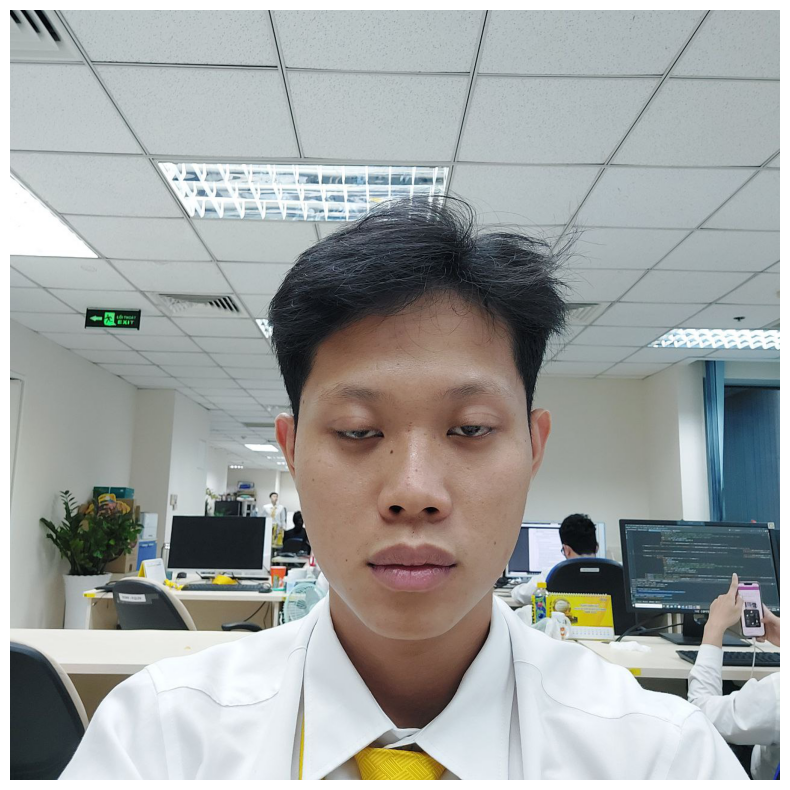

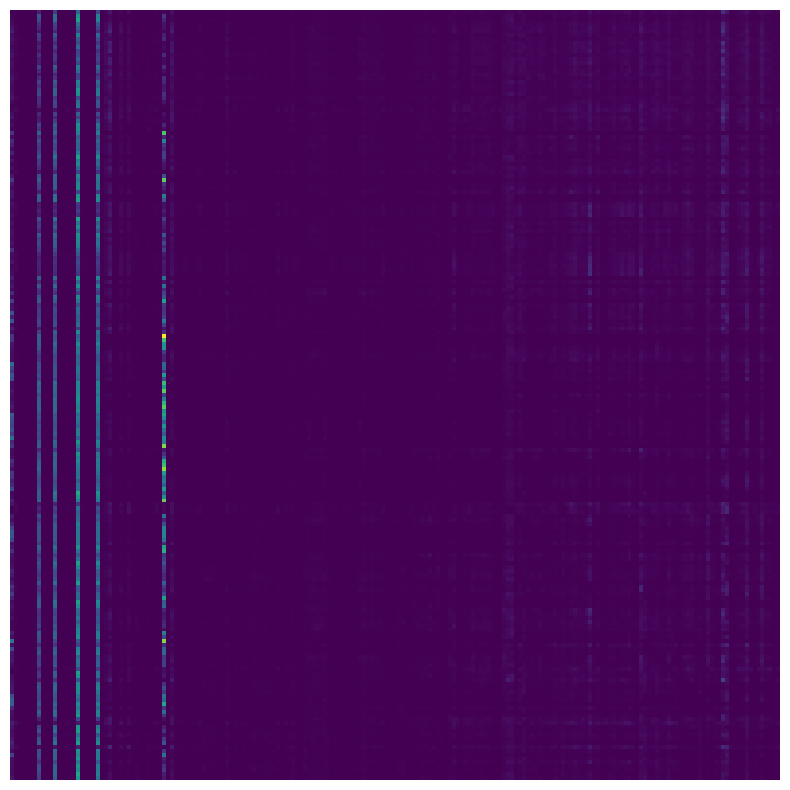

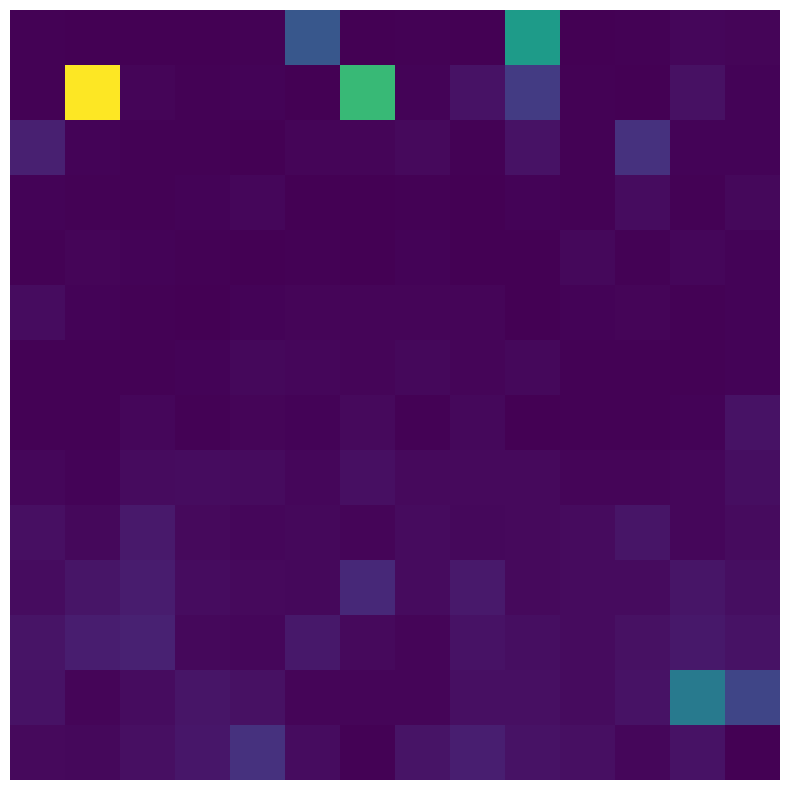

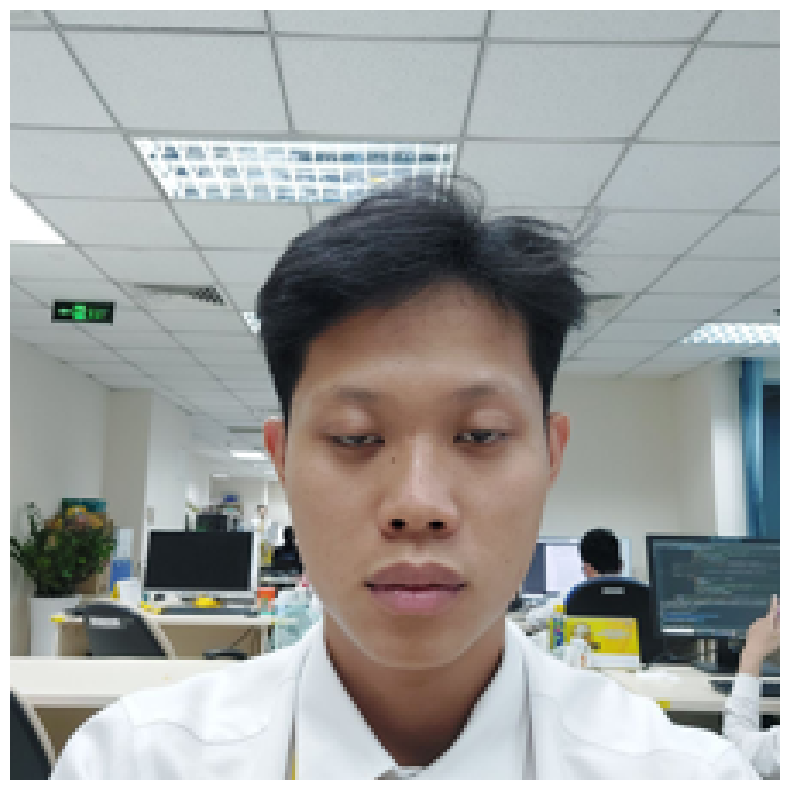

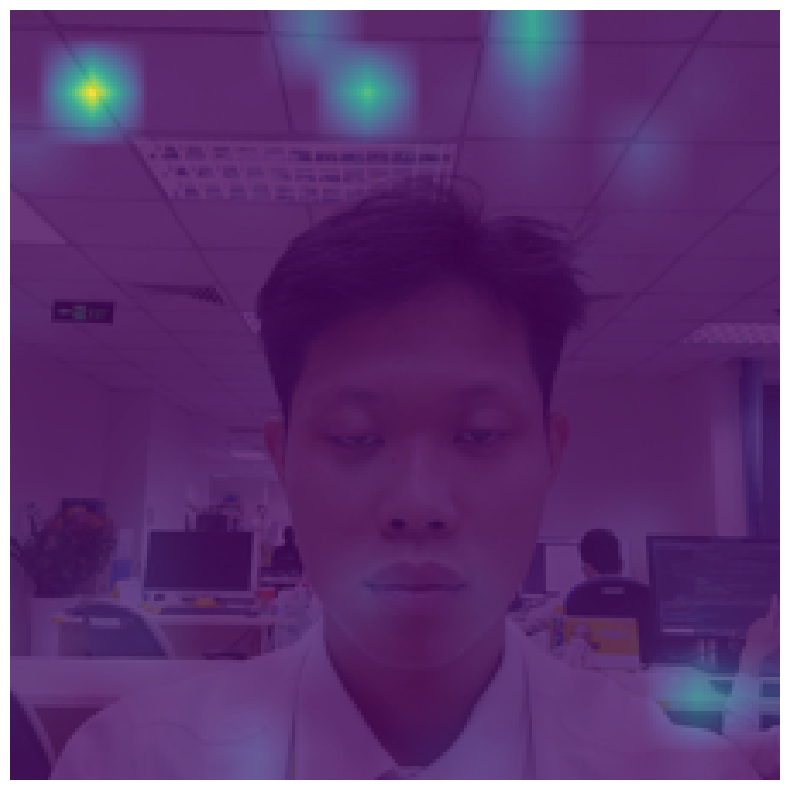

In [7]:
img = Image.open('image_test/realtwo.jpg')
x = to_tensor(img, device)

model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)

y = model(x.unsqueeze(0))
attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()

cls_attn_map = model.blocks[-1].attn.cls_attn_map.mean(dim=1)
padding = (0, 1)  # (left, right) padding for the last dimension
cls_attn_map_padded = F.pad(cls_attn_map, padding, mode='constant', value=0) # should pad so the sqrt(map_size) = input size

cls_weight = cls_attn_map_padded.view(map_size,map_size).detach()

img_resized = x.permute(1, 2, 0) * 0.5 + 0.5
cls_resized = F.interpolate(cls_weight.view(1, 1, map_size,map_size), (224, 224), mode='bilinear').view(224, 224, 1)


show_img(img)
show_img(attn_map)
show_img(cls_weight)
show_img(img_resized)
show_img2(img_resized, cls_resized, alpha=0.8)